In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

from data_preparation import CreateDataset,\
                             load_images_and_labels, \
                             encode_labels, \
                             create_data_augmentation

from trainer import train_model, \
                    plot_losses, \
                    evaluate_model

import boto3
import multiprocessing

num_workers = multiprocessing.cpu_count()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_num_threads(num_workers)

In [2]:
device

device(type='cuda')

In [3]:
BATCH_SIZE = 128

In [4]:
data = "fer2013"
bucket_name = 'thesissagemakerbucket'
train_path = f'{data}/train'
test_path = f'{data}/test'

X_train, y_train = load_images_and_labels(bucket_name, train_path)
X_test, y_test = load_images_and_labels(bucket_name, test_path)

In [5]:
X = X_train + X_test
y = y_train + y_test

# split into training and testing data using sklearn
X_train, X_test_and_val, y_train, y_test_and_val = train_test_split(X, y,
                                                    test_size=0.5,
                                                    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_test_and_val,
                                                y_test_and_val,
                                                test_size=0.5,
                                                random_state=42)

In [6]:
# label_encoder, y_train, y_test = encode_labels(y_train, y_test)
label_encoder, y_train, y_val, y_test = encode_labels(y_train, y_val, y_test)


In [7]:
transform = create_data_augmentation()

In [8]:
train_dataset = CreateDataset(X_train, y_train, transform=transform)
test_dataset = CreateDataset(X_test, y_test, transform=transform)
val_dataset = CreateDataset(X_val, y_val, transform=transform)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

In [10]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = None
        
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)
        
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 256).to(x.device)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        
        return x

In [11]:
model = SimpleCNN(num_classes=7)
model.to(device)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [12]:
optimizer = Adam(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()

best_model, train_losses, val_losses = train_model(
                                    model=model,
                                    train_loader=train_loader,
                                    val_loader=val_loader,
                                    criterion=criterion,
                                    optimizer=optimizer,
                                    device=device,
                                    epochs=500,
                                    patience=5
                                )

100%|██████████| 141/141 [00:48<00:00,  2.90it/s]


Epoch 1, Train Loss: 1.7948, Validation Loss: 1.7886


100%|██████████| 141/141 [00:48<00:00,  2.91it/s]


Epoch 2, Train Loss: 1.7773, Validation Loss: 1.7688


100%|██████████| 141/141 [00:47<00:00,  2.95it/s]


Epoch 3, Train Loss: 1.7748, Validation Loss: 1.7799


100%|██████████| 141/141 [00:48<00:00,  2.91it/s]


Epoch 4, Train Loss: 1.7668, Validation Loss: 1.7732


100%|██████████| 141/141 [00:47<00:00,  2.95it/s]


Epoch 5, Train Loss: 1.7598, Validation Loss: 1.7491


100%|██████████| 141/141 [00:47<00:00,  2.96it/s]


Epoch 6, Train Loss: 1.7597, Validation Loss: 1.7740


100%|██████████| 141/141 [00:47<00:00,  2.95it/s]


Epoch 7, Train Loss: 1.7538, Validation Loss: 1.7347


100%|██████████| 141/141 [00:47<00:00,  2.96it/s]


Epoch 8, Train Loss: 1.7508, Validation Loss: 1.7401


100%|██████████| 141/141 [00:48<00:00,  2.90it/s]


Epoch 9, Train Loss: 1.7468, Validation Loss: 1.7350


100%|██████████| 141/141 [00:48<00:00,  2.92it/s]


Epoch 10, Train Loss: 1.7467, Validation Loss: 1.7391


100%|██████████| 141/141 [00:47<00:00,  2.94it/s]


Epoch 11, Train Loss: 1.7393, Validation Loss: 1.7321


100%|██████████| 141/141 [00:47<00:00,  2.96it/s]


Epoch 12, Train Loss: 1.7363, Validation Loss: 1.7830


100%|██████████| 141/141 [00:48<00:00,  2.92it/s]


Epoch 13, Train Loss: 1.7301, Validation Loss: 1.7108


100%|██████████| 141/141 [00:47<00:00,  2.96it/s]


Epoch 14, Train Loss: 1.7262, Validation Loss: 1.7270


100%|██████████| 141/141 [00:48<00:00,  2.93it/s]


Epoch 15, Train Loss: 1.7200, Validation Loss: 1.7043


100%|██████████| 141/141 [00:48<00:00,  2.91it/s]


Epoch 16, Train Loss: 1.7157, Validation Loss: 1.6949


100%|██████████| 141/141 [00:47<00:00,  2.94it/s]


Epoch 17, Train Loss: 1.7077, Validation Loss: 1.7209


100%|██████████| 141/141 [00:48<00:00,  2.93it/s]


Epoch 18, Train Loss: 1.7040, Validation Loss: 1.7322


100%|██████████| 141/141 [00:47<00:00,  2.94it/s]


Epoch 19, Train Loss: 1.7036, Validation Loss: 1.6961


100%|██████████| 141/141 [00:48<00:00,  2.93it/s]


Epoch 20, Train Loss: 1.6956, Validation Loss: 1.7274


100%|██████████| 141/141 [00:48<00:00,  2.94it/s]


Epoch 21, Train Loss: 1.6908, Validation Loss: 1.6830


100%|██████████| 141/141 [00:48<00:00,  2.91it/s]


Epoch 22, Train Loss: 1.6888, Validation Loss: 1.6847


100%|██████████| 141/141 [00:47<00:00,  2.95it/s]


Epoch 23, Train Loss: 1.6925, Validation Loss: 1.7234


100%|██████████| 141/141 [00:47<00:00,  2.96it/s]


Epoch 24, Train Loss: 1.6881, Validation Loss: 1.6939


100%|██████████| 141/141 [00:48<00:00,  2.92it/s]


Epoch 25, Train Loss: 1.6810, Validation Loss: 1.6957


100%|██████████| 141/141 [00:47<00:00,  2.94it/s]


Epoch 26, Train Loss: 1.6821, Validation Loss: 1.6698


100%|██████████| 141/141 [00:47<00:00,  2.95it/s]


Epoch 27, Train Loss: 1.6810, Validation Loss: 1.6820


100%|██████████| 141/141 [00:47<00:00,  2.96it/s]


Epoch 28, Train Loss: 1.6758, Validation Loss: 1.6689


100%|██████████| 141/141 [00:47<00:00,  2.94it/s]


Epoch 29, Train Loss: 1.6700, Validation Loss: 1.6613


100%|██████████| 141/141 [00:48<00:00,  2.93it/s]


Epoch 30, Train Loss: 1.6750, Validation Loss: 1.6854


100%|██████████| 141/141 [00:47<00:00,  2.96it/s]


Epoch 31, Train Loss: 1.6684, Validation Loss: 1.6729


100%|██████████| 141/141 [00:47<00:00,  2.94it/s]


Epoch 32, Train Loss: 1.6654, Validation Loss: 1.6566


100%|██████████| 141/141 [00:47<00:00,  2.94it/s]


Epoch 33, Train Loss: 1.6629, Validation Loss: 1.6428


100%|██████████| 141/141 [00:48<00:00,  2.90it/s]


Epoch 34, Train Loss: 1.6669, Validation Loss: 1.6786


100%|██████████| 141/141 [00:47<00:00,  2.95it/s]


Epoch 35, Train Loss: 1.6634, Validation Loss: 1.6600


100%|██████████| 141/141 [00:47<00:00,  2.95it/s]


Epoch 36, Train Loss: 1.6570, Validation Loss: 1.6432


100%|██████████| 141/141 [00:47<00:00,  2.95it/s]


Epoch 37, Train Loss: 1.6510, Validation Loss: 1.6832


100%|██████████| 141/141 [00:47<00:00,  2.96it/s]


Epoch 38, Train Loss: 1.6531, Validation Loss: 1.6746
Early stopping triggered


In [13]:
model_dir = f'{data}/models'

model_path = f'cnn_{data}_model.pt'
torch.save(best_model.state_dict(), model_path)

s3 = boto3.client('s3')
s3.upload_file(model_path, bucket_name, os.path.join(model_dir, model_path))

os.remove(model_path)

In [14]:
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=100352, out_features=256, bias=True)
)

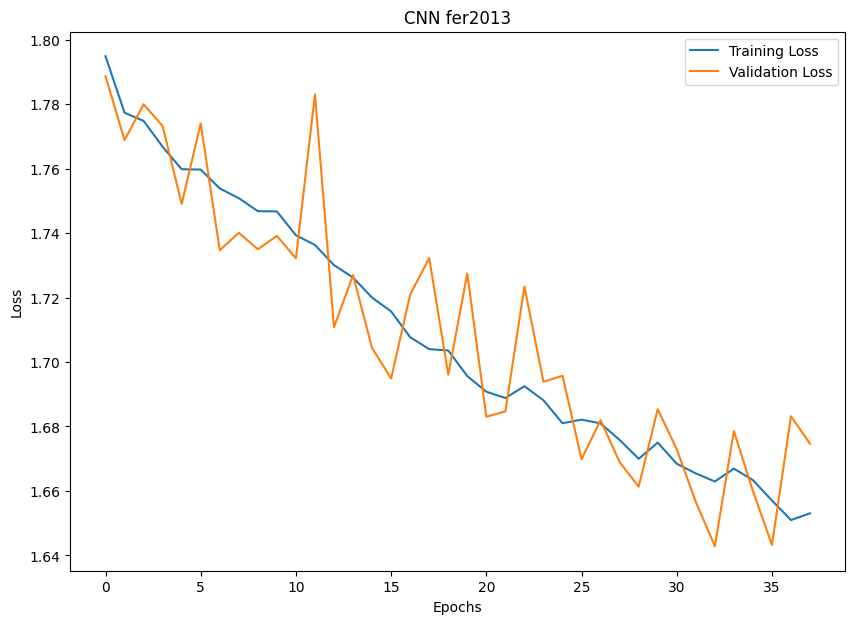

In [15]:
plot_losses(train_losses, val_losses, title=f"CNN {data}")

/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sagemaker-user/.cache/pypoetry/virtualenvs/masters-thesis-wHrfZheI-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

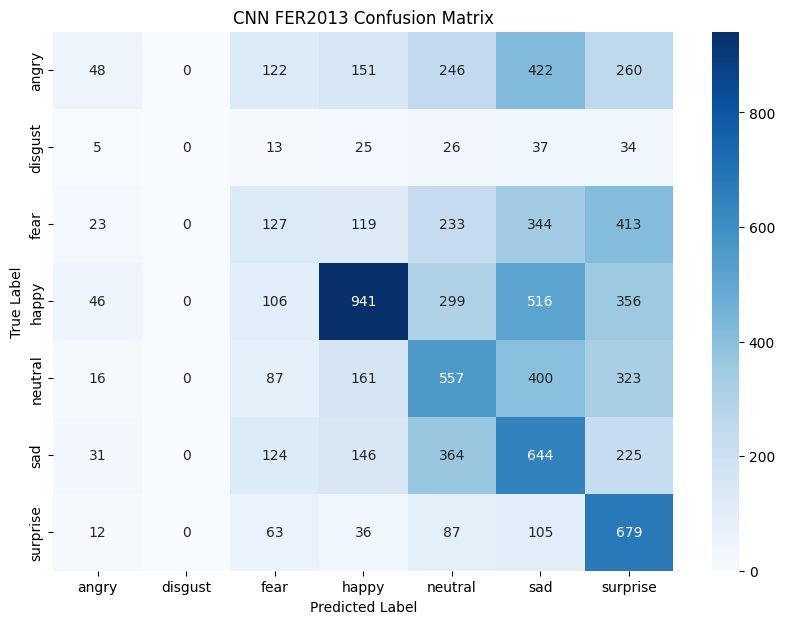

Test Accuracy: 0.3339
Precision: 0.2748
Recall: 0.2896
F1 Score: 0.2513
Classification Report:
               precision    recall  f1-score   support

       angry       0.27      0.04      0.07      1249
     disgust       0.00      0.00      0.00       140
        fear       0.20      0.10      0.13      1259
       happy       0.60      0.42      0.49      2264
     neutral       0.31      0.36      0.33      1544
         sad       0.26      0.42      0.32      1534
    surprise       0.30      0.69      0.42       982

    accuracy                           0.33      8972
   macro avg       0.27      0.29      0.25      8972
weighted avg       0.35      0.33      0.31      8972



In [16]:
evaluate_model(model=model,
               test_loader=test_loader,
               device=device,
               data=f"CNN {data}",
               label_encoder=label_encoder)